In [1]:
using Oceananigans
using NCDatasets
using CairoMakie
using Printf

In [2]:
rootdir = "../data/raw_output/"
filelist = [e for e in readdir(rootdir) if e[1]!="."[1]]

1-element Vector{String}:
 "shear_instability_state_Ri=0.1.nc"

In [3]:
include("../src/shear_instability.jl");
ds = NCDataset(string(rootdir, filelist[1]), "r");
simulation = initialize_shear_layer(ds.attrib["Ri"], output_writer=false)
model = simulation.model
grid = simulation.model.grid;

n_particles = 100


[ Info: Setting initial conditions


In [4]:
Δxᶜ = xspacings(grid, Center())
Δyᶜ = yspacings(grid, Center())
Δzᶜ = zspacings(grid, Center())

ΔVᶜ = Δxᶜ*Δyᶜ*Δzᶜ;

In [5]:
ds = NCDataset(string(rootdir, filelist[1]), "r");
t = ds["time"];
c = ds["c"]
M = sum(c*ΔVᶜ, dims=(1,2,3));

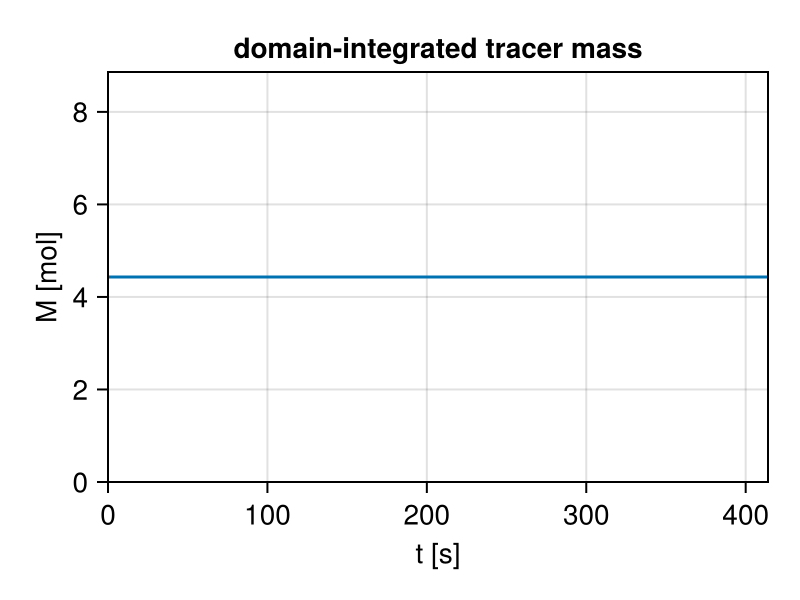

In [6]:
fig = Figure(size=(400, 300))
kwargs = (xlabel="t [s]", ylabel="M [mol]", limits = ((0, maximum(ds["time"])), (0, nothing)))
title = @sprintf("domain-integrated tracer mass")
ax = Axis(fig[1, 1]; title = title, kwargs...)
lines!(ax, t, M[1,1,1,:])
fig

In [7]:
z = reshape(ds["zC"], (1,1,length(ds["zC"]), 1))
z̄ = sum(z.*c*ΔVᶜ, dims=(1,2,3)) ./ M;

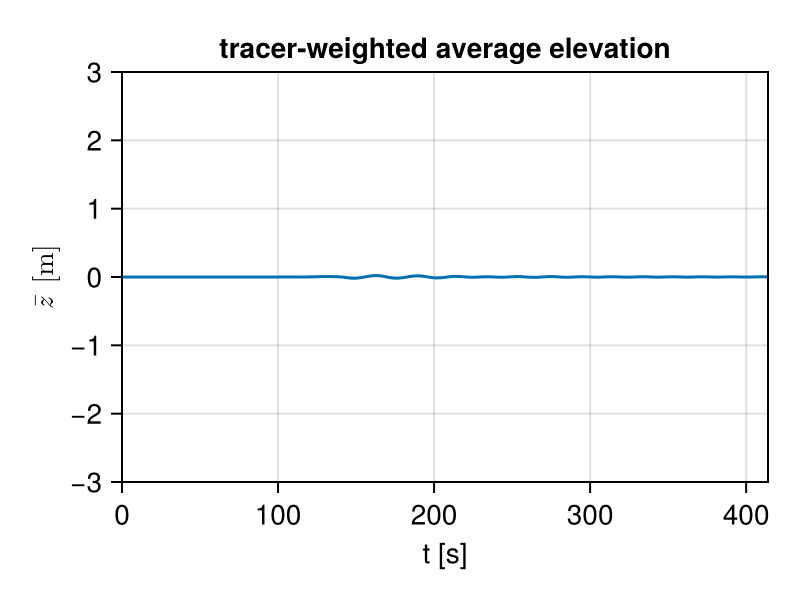

In [8]:
fig = Figure(size=(400, 300))
kwargs = (xlabel="t [s]", ylabel=L"$\bar{z}$ [m]", limits = ((0, maximum(ds["time"])), (-3, 3)))
title = @sprintf("tracer-weighted average elevation")
ax = Axis(fig[1, 1]; title = title, kwargs...)
lines!(ax, t, z̄[1,1,1,:])
fig

In [ ]:
z′ = z.-z̄
zvar = sum((z′.^2).*c*ΔVᶜ, dims=(1,2,3)) ./ M;
zσ = sqrt.(zvar);

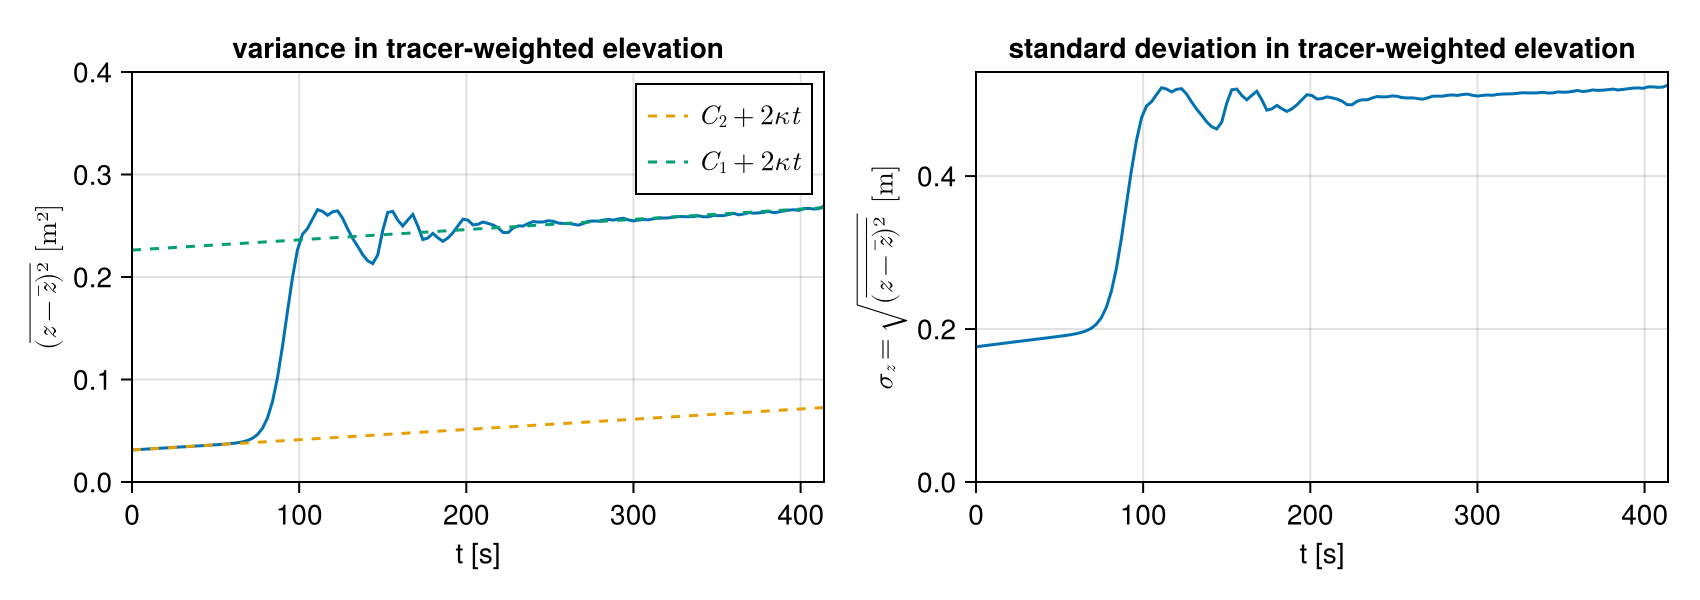

In [10]:
fig = Figure(size=(850, 300))
kwargs = (xlabel="t [s]", ylabel=L"$\overline{(z-z̄)²}$ [m²]", limits = ((0, maximum(ds["time"])), (0, 0.4)))
title = @sprintf("variance in tracer-weighted elevation")
ax = Axis(fig[1, 1]; title = title, kwargs...)
lines!(ax, t, zvar[1,1,1,:])
lines!(ax, t, zvar[1,1,1,1] .+ 2*model.closure.κ.c*t, linestyle=:dash, label=L"$C_{2} + 2 \kappa t$")
lines!(ax, t, zvar[1,1,1,1] + 0.195 .+ 2*model.closure.κ.c*t, linestyle=:dash, label=L"$C_{1} + 2 \kappa t$")
axislegend(ax)

kwargs = (xlabel="t [s]", ylabel=L"$\sigma_{z} = \sqrt{\overline{(z-z̄)²}}$ [m]", limits = ((0, maximum(ds["time"])), (0, nothing)))
title = @sprintf("standard deviation in tracer-weighted elevation")
ax = Axis(fig[1, 2]; title = title, kwargs...)
lines!(ax, t, zσ[1,1,1,:])

fig

In [11]:
close(ds)

closed Dataset